#Introduction

In this notebook we will use a clustering algorithm to analyze our data (i.e. YouTube comments of a single video).
This will help us extract topics of discussion.
We use the embeddings generated in Assignment 4 as input. 
(This notebook will not run without first running the assignment 4 Notebook, as it relies on the data in the folder 'output/')
Each of our comments has been assigned a vector that encodes information about its meaning.
The closer two vectors are, the more similar the meaning.

Each vector is of 512 Dimensions.

Before we can cluster our data we need to reduce the embeddings' dimensionality to overcome the curse of dimensionality.
We use the UMAP ALgorithm for this.

After that we use the KMedoids Algorithm to partition the embedding space and generate our clusters this way.

We need to define the number of clusters we want to have. 
To find the optimal number of clusters, we use a simple optimization scheme.

Once the clusters are created, we visualize them.
To do this we reduce the dimensionality of the embeddings again to two dimensions.
Then we render a scatterplot of our data.

Furthermore we want to analyze and interpret our clusters.
To do this, we:
- print some statistics about each of the clusters
- print cluster's medoid (the central sample)
- print the cluster(s) we want to analyze further

Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [1]:
#!which python
import sys
sys.executable

'C:\\Users\\moritz\\anaconda3\\envs\\social-2\\python.exe'

# Install dependencies:

In [2]:
install_packages = False
if install_packages:    
    !conda install -c conda-forge umap-learn -y
    !conda install -c conda-forge scikit-learn-extra -y

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\moritz\anaconda3\envs\social-2

  added / updated specs:
    - umap-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.12.5  |       h5b45459_0         173 KB  conda-forge
    certifi-2020.12.5          |   py36ha15d459_0         143 KB  conda-forge
    llvmlite-0.35.0            |   py36haecd60e_0        15.1 MB  conda-forge
    numba-0.52.0               |   py36he38d939_0         3.6 MB  conda-forge
    openssl-1.1.1h             |       he774522_0         5.8 MB  conda-forge
    tbb-2020.1                 |       he980bc4_0         167 KB  conda-forge
    umap-learn-0.4.6           |   py36h9f0ad1d_0         111 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        25.0 MB

The follo

# Imports

In [2]:
#imports

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

# Functions to Save and load manually

In [3]:
# Save and load your data after clustering

def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')
    
def load_results():
    data = pd.read_pickle(output_path+'data_clustered'+'.pkl')
    

Set pandas print options
This will improve readability of printed pandas dataframe.


In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

output_path: Files generated in this notebook will be saved here.

model_type: Define which model was used to produce the embeddings. (Check the name of the .npy-file containing the embeddings)

In [5]:
output_path = "./output/"
model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

# Load Data
Load the preprocessed data as a pandas dataframe.
And load the embeddings as a numpy ndarray (a matrix in our case).

In [6]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [7]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

# Dimensionality reduction with UMAP

We reduce the number of dimensions of our embeddings to make possibly present clusters more pronounced. 
The number of dimensions (num_dimensions) depends on the number of samples

In [8]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

# Optimize the Number of Clusters

n_clusters: 2 silhouette_avg: 0.4813005
n_clusters: 102 silhouette_avg: 0.30111217
n_clusters: 202 silhouette_avg: 0.30236855
n_clusters: 302 silhouette_avg: 0.30718055
n_clusters: 402 silhouette_avg: 0.30190834
n_clusters: 502 silhouette_avg: 0.29498798
n_clusters: 602 silhouette_avg: 0.28400204
n_clusters: 702 silhouette_avg: 0.27109143
n_clusters: 802 silhouette_avg: 0.256906
n_clusters: 902 silhouette_avg: 0.23993453


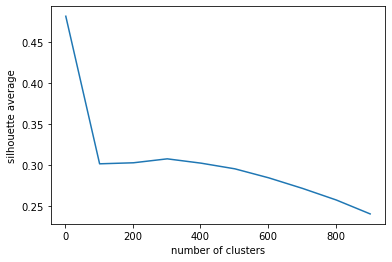

In [9]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=2 
max_clusters=1000 
step=100 

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

# Clustering with KMedoids

In [10]:
number_of_clusters =  100
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 91     1
41     1
45     2
75     2
96     2
98     3
26     3
14     3
74     4
60     4
16     4
23     5
47     5
99     5
79     5
88     5
71     5
29     6
62     6
90     6
39     7
25     7
57     7
30     7
54     7
40     7
80     8
81     8
68     8
11     8
86     8
82     8
85     8
27     8
66     8
61     9
31     9
44     9
53     9
55     9
89     9
73    10
83    10
48    10
22    10
38    10
36    10
35    11
84    11
9     11
76    11
94    11
63    11
77    12
4     12
12    12
87    12
50    13
93    13
10    15
58    16
56    17
32    18
37    18
52    18
95    18
51    18
49    18
0     19
59    20
70    20
42    20
18    21
65    21
72    21
46    22
28    22
19    23
8     23
97    23
67    23
13    24
33    25
5     25
24    26
92    27
3     28
20    29
43    29
6     30
78    31
2     32
64    32
69    33
1     36
21    38
34    40
17    45
7     48
15    63
Name: label_kmedoids, dtype: int64


In [11]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

# Dimensionality Reduction for Visualization

In [12]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_visualization.fit_transform(embeddings)

C:\Users\moritz\anaconda3\envs\social-2\lib\site-packages\umap\umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


# Visualize clustering results

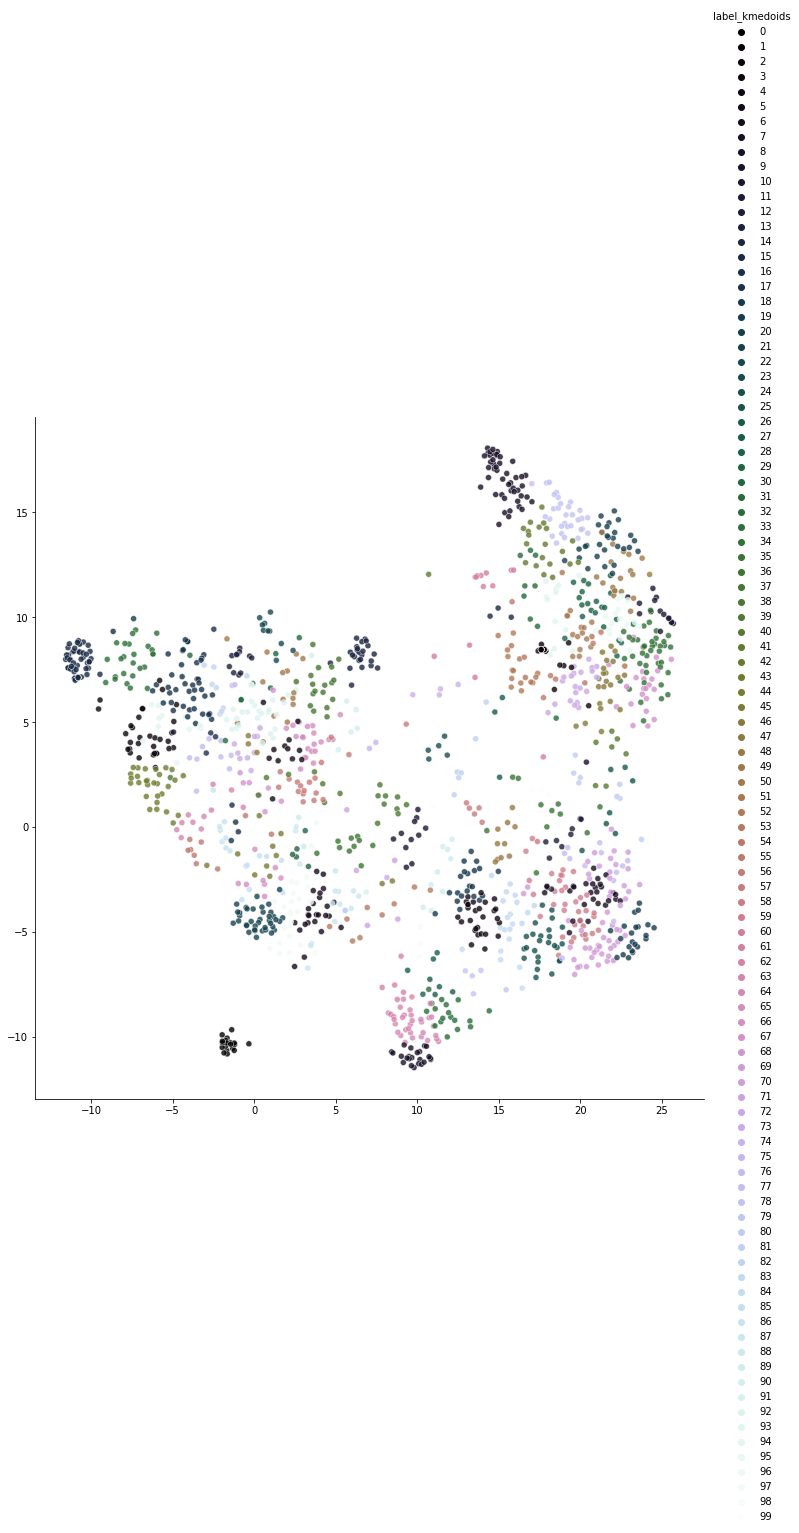

In [79]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "cubehelix" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.80 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)


## Highlight one cluster

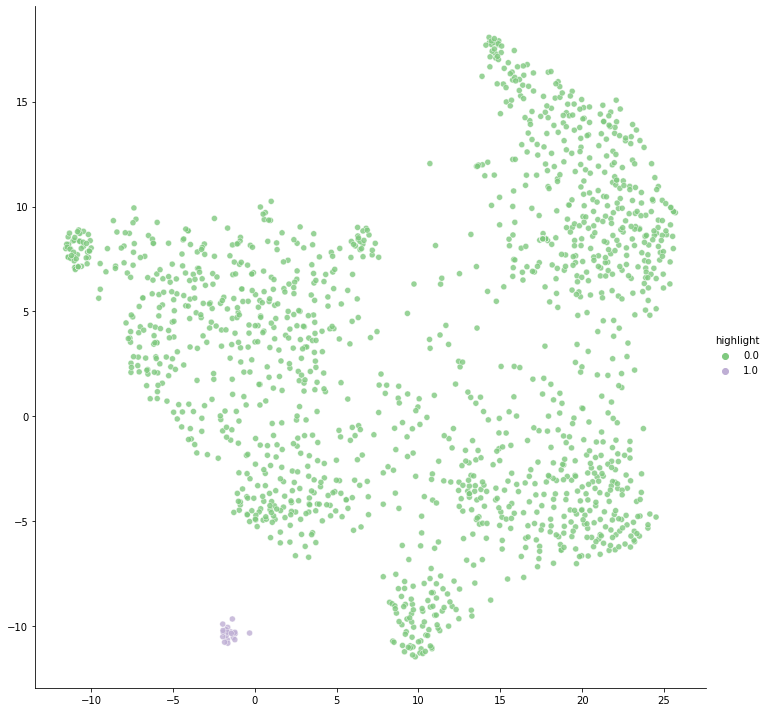

In [86]:
## Choose a cluster to higlight:
cluster_num = 0

data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)


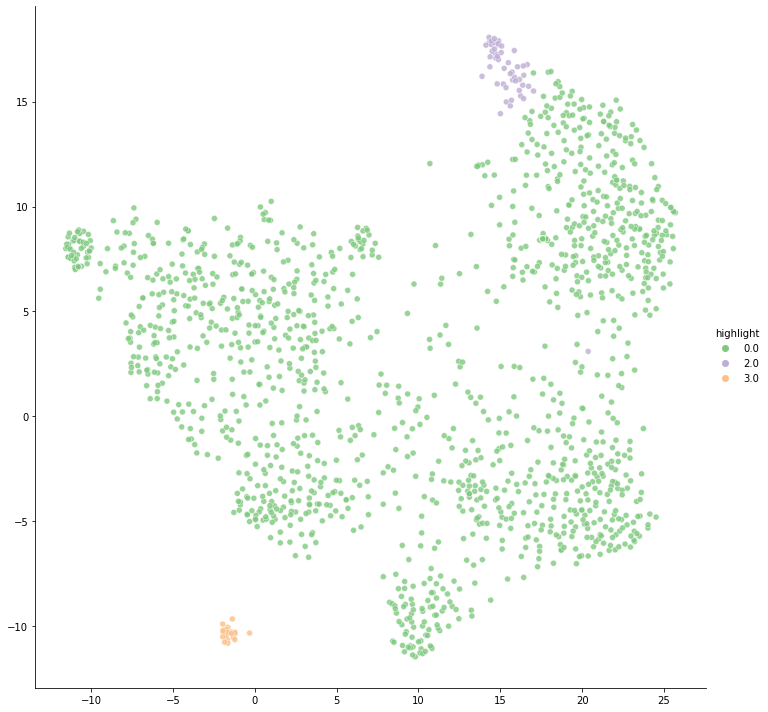

In [89]:
## Choose a cluster to higlight:

data['highlight'] = np.zeros(len(data.index))

data.loc[data['label_kmedoids'] == 7, 'highlight'] = 2
data.loc[data['label_kmedoids'] == 0, 'highlight'] = 3


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)

# Print Medoids and cluster statistics

In [16]:
# print the medoids 
data.iloc[medoids_indices]      

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
75,2020-09-17 12:45:02,Parvis,Joe Biden just says what people want to hear. At least Trump is usually honest even if it’s at his expense,0,Joe Biden just says what people want to hear. At least Trump is usually honest\neven if it’s at his expense\n\n,-1.0,0,2.980232e-07,0.0
1101,2020-09-15 02:48:28,Taylor Michael Holt,D.E.W. Directed Energy Weapons. How come almost zero fires are in Mexico or Canada? California and Oregon were denied federal funding. If there is natural disaster they get federal funding through FEMA. Climate Change is the issue the technocrats want to enable it. Environmental Health is the true issue. Wake up and grow up.,1,D.E.W. Directed Energy Weapons. How come almost zero fires are in Mexico or\nCanada? California and Oregon were denied federal funding. If there is natural\ndisaster they get federal funding through FEMA. Climate Change is the issue\nthe technocrats want to enable it. Environmental Health is the true issue.\nWake up and grow up.\n\n,-1.0,1,0.000000e+00,2.0
1116,2020-09-23 09:31:11,Eli Goldie,@retro1980 what agenda?,1,@ what agenda?\n\n,-1.0,2,0.000000e+00,0.0
1404,2020-09-14 21:10:30,Robot Head,He knows like most of us know global warming/Climate change is FAKE NEWS made up by the globalist cabal,0,He knows like most of us know global warming/Climate change is FAKE NEWS made\nup by the globalist cabal\n\n,-1.0,3,0.000000e+00,0.0
440,2020-09-15 02:48:54,Sailex W,The ignorance is painful to watch...,0,The ignorance is painful to watch...\n\n,-1.0,4,1.788139e-07,1.0
218,2020-09-15 13:35:40,onlyonewhyphy,According to <b>ALL THE MEDIA</b> Trump never does anything right.<br />Seems somehow untrue,0,According to **ALL THE MEDIA** Trump never does anything right. \nSeems somehow untrue\n\n,-1.0,5,1.192093e-07,0.0
1119,2020-09-18 05:16:51,Athul Kathul,"@Paul Actually, we do have evidence. We know that climate change can be caused by CO2 in the atmosphere, and other greenhouse gases, among many things and we also know that the climate is changing the fastest it has ever because CO2 levels in the atmosphere is rising the fastest it has ever, except when the Earth was being formed, and the CO2 emissions are caused by us more than anything else in the world which is proof enough that we're the cause of this sudden rise in climate",1,"@Paul Actually, we do have evidence. We know that climate change can be caused\nby CO2 in the atmosphere, and other greenhouse gases, among many things and we\nalso know that the climate is changing the fastest it has ever because CO2\nlevels in the atmosphere is rising the fastest it has ever, except when the\nEarth was being formed, and the CO2 emissions are caused by us more than\nanything else in the world which is proof enough that we're the cause of this\nsudden rise in climate\n\n",-1.0,6,0.000000e+00,0.0
1203,2020-09-15 03:13:48,Callumbia Snow,"It’s funny that America fought a civil war for BLM, a world war for antifa and is the main insurgent force in the middle east. Have some respect for veterans.",1,"It’s funny that America fought a civil war for BLM, a world war for antifa and\nis the main insurgent force in the middle east. Have some respect for\nveterans.\n\n",-1.0,7,0.000000e+00,0.0
1172,2020-09-14 23:54:01,Buttbanging Trannyliberal,It's not science starting em! It's Liberals.,1,It's not science starting em! It's Liberals.\n\n,-1.0,8,0.000000e+00,0.0
1284,2020-09-14 21:45:35,Rotulino Rolon,The man who said the virus will go away on April with the hot weather now saying California is going to cool.. only low IQ maggots can believe this trump imbecile,0,The man who said the virus will go away on April with the hot weather now\nsaying California is going to cool.. only low IQ maggots can believe this\ntrump imbecile\n\n,-1.0,9,1.788139e-07,0.0


In [17]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

0 number of samples:  19 mean distance from center:  0.00013269876717458828 Proportion of replies: 31.57894736842105
1 number of samples:  36 mean distance from center:  0.00042219958231726196 Proportion of replies: 88.88888888888889
2 number of samples:  32 mean distance from center:  0.0016568228602409363 Proportion of replies: 78.125
3 number of samples:  28 mean distance from center:  0.00101668492789031 Proportion of replies: 14.285714285714286
4 number of samples:  12 mean distance from center:  0.001455843448638916 Proportion of replies: 83.33333333333333
5 number of samples:  25 mean distance from center:  0.0013227462659415323 Proportion of replies: 32.0
6 number of samples:  30 mean distance from center:  0.0015670060747652315 Proportion of replies: 83.33333333333333
7 number of samples:  48 mean distance from center:  0.0011590619578782935 Proportion of replies: 45.833333333333336
8 number of samples:  23 mean distance from center:  0.0004602515218721237 Proportion of replie

# Print Cluster
Print the comments within a cluster. Comments are sorted by their distance from the cluster medoid

In [55]:
# Choose a cluster to print
cluster_number =   1
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster


Number of samples in the cluster: 36
Average Distance from cluster center: 4.221996e-06


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
1048,2020-09-15 02:50:02,Taylor Michael Holt,D.E.W. Directed Energy Weapons. How come almost zero fires are in Mexico or Canada? California and Oregon were denied federal funding. If there is natural disaster they get federal funding through FEMA. Climate Change is the issue the technocrats want to enable it. Environmental Health is the true issue. Wake up and grow up.,1,D.E.W. Directed Energy Weapons. How come almost zero fires are in Mexico or\nCanada? California and Oregon were denied federal funding. If there is natural\ndisaster they get federal funding through FEMA. Climate Change is the issue\nthe technocrats want to enable it. Environmental Health is the true issue.\nWake up and grow up.\n\n,DEW Spam,1,0.000000e+00,2.0
1487,2020-09-15 02:49:57,Taylor Michael Holt,D.E.W. Directed Energy Weapons. How come almost zero fires are in Mexico or Canada? California and Oregon were denied federal funding. If there is natural disaster they get federal funding through FEMA. Climate Change is the issue the technocrats want to enable it. Environmental Health is the true issue. Wake up and grow up.,1,D.E.W. Directed Energy Weapons. How come almost zero fires are in Mexico or\nCanada? California and Oregon were denied federal funding. If there is natural\ndisaster they get federal funding through FEMA. Climate Change is the issue\nthe technocrats want to enable it. Environmental Health is the true issue.\nWake up and grow up.\n\n,DEW Spam,1,0.000000e+00,2.0
1412,2020-09-15 02:50:26,Taylor Michael Holt,D.E.W. Directed Energy Weapons. How come almost zero fires are in Mexico or Canada? California and Oregon were denied federal funding. If there is natural disaster they get federal funding through FEMA. Climate Change is the issue the technocrats want to enable it. Environmental Health is the true issue. Wake up and grow up.,1,D.E.W. Directed Energy Weapons. How come almost zero fires are in Mexico or\nCanada? California and Oregon were denied federal funding. If there is natural\ndisaster they get federal funding through FEMA. Climate Change is the issue\nthe technocrats want to enable it. Environmental Health is the true issue.\nWake up and grow up.\n\n,DEW Spam,1,0.000000e+00,2.0
1391,2020-09-15 02:51:50,Taylor Michael Holt,D.E.W. Directed Energy Weapons. How come almost zero fires are in Mexico or Canada? California and Oregon were denied federal funding. If there is natural disaster they get federal funding through FEMA. Climate Change is the issue the technocrats want to enable it. Environmental Health is the true issue. Wake up and grow up.,1,D.E.W. Directed Energy Weapons. How come almost zero fires are in Mexico or\nCanada? California and Oregon were denied federal funding. If there is natural\ndisaster they get federal funding through FEMA. Climate Change is the issue\nthe technocrats want to enable it. Environmental Health is the true issue.\nWake up and grow up.\n\n,DEW Spam,1,0.000000e+00,2.0
1388,2020-09-15 02:52:18,Taylor Michael Holt,D.E.W. Directed Energy Weapons. How come almost zero fires are in Mexico or Canada? California and Oregon were denied federal funding. If there is natural disaster they get federal funding through FEMA. Climate Change is the issue the technocrats want to enable it. Environmental Health is the true issue. Wake up and grow up.,1,D.E.W. Directed Energy Weapons. How come almost zero fires are in Mexico or\nCanada? California and Oregon were denied federal funding. If there is natural\ndisaster they get federal funding through FEMA. Climate Change is the issue\nthe technocrats want to enable it. Environmental Health is the true issue.\nWake up and grow up.\n\n,DEW Spam,1,0.000000e+00,2.0
1373,2020-09-15 02:52:02,Taylor Michael Holt,D.E.W. Directed Energy Weapons. How come almost zero fires are in Mexico or Canada? California and Oregon were denied federal funding. If there is natural disaster they 

# Assign Cluster labels manually
cluster_number: which cluster would you like to assign labels to?
min_distance: the minimum distance from the cluster medoid be for a data point to still get the specified label
max_distance: the maximum distance from the cluster medoid be for a data point to still get the specified label
label_manual: your label

In [56]:
#which cluster would you like to assign labels to?
cluster_number = 1
#your label
label_manual = 'DEW Spam'

#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [57]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
1048,2020-09-15 02:50:02,Taylor Michael Holt,D.E.W. Directed Energy Weapons. How come almost zero fires are in Mexico or Canada? California and Oregon were denied federal funding. If there is natural disaster they get federal funding through FEMA. Climate Change is the issue the technocrats want to enable it. Environmental Health is the true issue. Wake up and grow up.,1,D.E.W. Directed Energy Weapons. How come almost zero fires are in Mexico or\nCanada? California and Oregon were denied federal funding. If there is natural\ndisaster they get federal funding through FEMA. Climate Change is the issue\nthe technocrats want to enable it. Environmental Health is the true issue.\nWake up and grow up.\n\n,DEW Spam,1,0.000000e+00,2.0
1487,2020-09-15 02:49:57,Taylor Michael Holt,D.E.W. Directed Energy Weapons. How come almost zero fires are in Mexico or Canada? California and Oregon were denied federal funding. If there is natural disaster they get federal funding through FEMA. Climate Change is the issue the technocrats want to enable it. Environmental Health is the true issue. Wake up and grow up.,1,D.E.W. Directed Energy Weapons. How come almost zero fires are in Mexico or\nCanada? California and Oregon were denied federal funding. If there is natural\ndisaster they get federal funding through FEMA. Climate Change is the issue\nthe technocrats want to enable it. Environmental Health is the true issue.\nWake up and grow up.\n\n,DEW Spam,1,0.000000e+00,2.0
1412,2020-09-15 02:50:26,Taylor Michael Holt,D.E.W. Directed Energy Weapons. How come almost zero fires are in Mexico or Canada? California and Oregon were denied federal funding. If there is natural disaster they get federal funding through FEMA. Climate Change is the issue the technocrats want to enable it. Environmental Health is the true issue. Wake up and grow up.,1,D.E.W. Directed Energy Weapons. How come almost zero fires are in Mexico or\nCanada? California and Oregon were denied federal funding. If there is natural\ndisaster they get federal funding through FEMA. Climate Change is the issue\nthe technocrats want to enable it. Environmental Health is the true issue.\nWake up and grow up.\n\n,DEW Spam,1,0.000000e+00,2.0
1391,2020-09-15 02:51:50,Taylor Michael Holt,D.E.W. Directed Energy Weapons. How come almost zero fires are in Mexico or Canada? California and Oregon were denied federal funding. If there is natural disaster they get federal funding through FEMA. Climate Change is the issue the technocrats want to enable it. Environmental Health is the true issue. Wake up and grow up.,1,D.E.W. Directed Energy Weapons. How come almost zero fires are in Mexico or\nCanada? California and Oregon were denied federal funding. If there is natural\ndisaster they get federal funding through FEMA. Climate Change is the issue\nthe technocrats want to enable it. Environmental Health is the true issue.\nWake up and grow up.\n\n,DEW Spam,1,0.000000e+00,2.0
1388,2020-09-15 02:52:18,Taylor Michael Holt,D.E.W. Directed Energy Weapons. How come almost zero fires are in Mexico or Canada? California and Oregon were denied federal funding. If there is natural disaster they get federal funding through FEMA. Climate Change is the issue the technocrats want to enable it. Environmental Health is the true issue. Wake up and grow up.,1,D.E.W. Directed Energy Weapons. How come almost zero fires are in Mexico or\nCanada? California and Oregon were denied federal funding. If there is natural\ndisaster they get federal funding through FEMA. Climate Change is the issue\nthe technocrats want to enable it. Environmental Health is the true issue.\nWake up and grow up.\n\n,DEW Spam,1,0.000000e+00,2.0
1373,2020-09-15 02:52:02,Taylor Michael Holt,D.E.W. Directed Energy Weapons. How come almost zero fires are in Mexico or Canada? California and Oregon were denied federal funding. If there is natural disaster they 

In [58]:
# Choose a cluster to print
cluster_number =   3
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster

Number of samples in the cluster: 28
Average Distance from cluster center: 1.0166849e-05


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
1404,2020-09-14 21:10:30,Robot Head,He knows like most of us know global warming/Climate change is FAKE NEWS made up by the globalist cabal,0,He knows like most of us know global warming/Climate change is FAKE NEWS made\nup by the globalist cabal\n\n,denying climate change,3,0.000000,0.0
243,2020-09-15 08:38:46,Ollie Odebunmi,"One has to be an idiot not to be aware of changes in the world&#39;s climate. But contrary to what we are led to believe there&#39;s no scientific consensus on its causes. Many climatologists/scientists whose opinions differ from the official narrative are marginalised and denied airtime, with 16 year old &quot;experts&quot; like Greta Thunberg given excessive coverage. Can&#39;t abide Trump, but he is right. &quot;Science doesn&#39;t know.&quot;",0,"One has to be an idiot not to be aware of changes in the world's climate. But\ncontrary to what we are led to believe there's no scientific consensus on its\ncauses. Many climatologists/scientists whose opinions differ from the official\nnarrative are marginalised and denied airtime, with 16 year old ""experts"" like\nGreta Thunberg given excessive coverage. Can't abide Trump, but he is right.\n""Science doesn't know.""\n\n",denying climate change,3,0.000001,0.0
762,2020-09-14 23:44:04,D Me,So now Donnie Dumbass is a climate expert. He&#39;s an expert on being a frickin&#39; dickhead.,0,So now Donnie Dumbass is a climate expert. He's an expert on being a frickin'\ndickhead.\n\n,denying climate change,3,0.000003,0.0
408,2020-09-15 03:42:40,Le Pifience,Read some of the works by Robert Carlson (watch the first 20 mins of his joe rogan interview. He’s a geologist and comes with hard facts about weathering and global warming over the last 10000 years. Watch that first 20 mins then do your own research). Trump isn’t stupid and isn’t being coy. ‘I don’t think science knows’ is a truly genuine statement.,0,Read some of the works by Robert Carlson (watch the first 20 mins of his joe\nrogan interview. He’s a geologist and comes with hard facts about weathering\nand global warming over the last 10000 years. Watch that first 20 mins then do\nyour own research). Trump isn’t stupid and isn’t being coy. ‘I don’t think\nscience knows’ is a truly genuine statement.\n\n,denying climate change,3,0.000004,0.0
1153,2020-09-15 03:43:26,Le Pifience,Read some of the works by Robert Carlson (watch the first 20 mins of his joe rogan interview. He’s a geologist and comes with hard facts about weathering and global warming over the last 10000 years. Watch that first 20 mins then do your own research). Trump isn’t stupid and isn’t being coy. ‘I don’t think science knows’ is a truly genuine statement.,1,Read some of the works by Robert Carlson (watch the first 20 mins of his joe\nrogan interview. He’s a geologist and comes with hard facts about weathering\nand global warming over the last 10000 years. Watch that first 20 mins then do\nyour own research). Trump isn’t stupid and isn’t being coy. ‘I don’t think\nscience knows’ is a truly genuine statement.\n\n,denying climate change,3,0.000004,0.0
1461,2020-09-14 20:56:20,dirin dirin,"Who wanna teach him who wanna tell him that Mr.peanut butter it is not &quot;chinese hoax&quot; it is real,have been called climate change. Come back to Paris agreement.",0,"Who wanna teach him who wanna tell him that Mr.peanut butter it is not\n""chinese hoax"" it is real,have been called climate change. Come back to Paris\nagreement.\n\n",denying climate change,3,0.000005,0.0
89,2020-09-17 02:03:37,Crazy Funny Cats,Trump is CORRECT! Global cooling ...Maunder minimum look it up!<br /><br />Suspicious Observers channel 👍learn shitloads of real spaceweather and earth science,0,Trump is CORRECT! Global cooling ...Maunder minimum look it up! \n \nSuspicious Observers channel 👍learn shitloads of real spaceweather and earth\nscience\n\n,denying climate change,3,0.00

In [59]:
#which cluster would you like to assign labels to?
cluster_number = 3
#your label
label_manual = 'denying climate change'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
1404,2020-09-14 21:10:30,Robot Head,He knows like most of us know global warming/Climate change is FAKE NEWS made up by the globalist cabal,0,He knows like most of us know global warming/Climate change is FAKE NEWS made\nup by the globalist cabal\n\n,denying climate change,3,0.000000,0.0
243,2020-09-15 08:38:46,Ollie Odebunmi,"One has to be an idiot not to be aware of changes in the world&#39;s climate. But contrary to what we are led to believe there&#39;s no scientific consensus on its causes. Many climatologists/scientists whose opinions differ from the official narrative are marginalised and denied airtime, with 16 year old &quot;experts&quot; like Greta Thunberg given excessive coverage. Can&#39;t abide Trump, but he is right. &quot;Science doesn&#39;t know.&quot;",0,"One has to be an idiot not to be aware of changes in the world's climate. But\ncontrary to what we are led to believe there's no scientific consensus on its\ncauses. Many climatologists/scientists whose opinions differ from the official\nnarrative are marginalised and denied airtime, with 16 year old ""experts"" like\nGreta Thunberg given excessive coverage. Can't abide Trump, but he is right.\n""Science doesn't know.""\n\n",denying climate change,3,0.000001,0.0
762,2020-09-14 23:44:04,D Me,So now Donnie Dumbass is a climate expert. He&#39;s an expert on being a frickin&#39; dickhead.,0,So now Donnie Dumbass is a climate expert. He's an expert on being a frickin'\ndickhead.\n\n,denying climate change,3,0.000003,0.0
408,2020-09-15 03:42:40,Le Pifience,Read some of the works by Robert Carlson (watch the first 20 mins of his joe rogan interview. He’s a geologist and comes with hard facts about weathering and global warming over the last 10000 years. Watch that first 20 mins then do your own research). Trump isn’t stupid and isn’t being coy. ‘I don’t think science knows’ is a truly genuine statement.,0,Read some of the works by Robert Carlson (watch the first 20 mins of his joe\nrogan interview. He’s a geologist and comes with hard facts about weathering\nand global warming over the last 10000 years. Watch that first 20 mins then do\nyour own research). Trump isn’t stupid and isn’t being coy. ‘I don’t think\nscience knows’ is a truly genuine statement.\n\n,denying climate change,3,0.000004,0.0
1153,2020-09-15 03:43:26,Le Pifience,Read some of the works by Robert Carlson (watch the first 20 mins of his joe rogan interview. He’s a geologist and comes with hard facts about weathering and global warming over the last 10000 years. Watch that first 20 mins then do your own research). Trump isn’t stupid and isn’t being coy. ‘I don’t think science knows’ is a truly genuine statement.,1,Read some of the works by Robert Carlson (watch the first 20 mins of his joe\nrogan interview. He’s a geologist and comes with hard facts about weathering\nand global warming over the last 10000 years. Watch that first 20 mins then do\nyour own research). Trump isn’t stupid and isn’t being coy. ‘I don’t think\nscience knows’ is a truly genuine statement.\n\n,denying climate change,3,0.000004,0.0
1461,2020-09-14 20:56:20,dirin dirin,"Who wanna teach him who wanna tell him that Mr.peanut butter it is not &quot;chinese hoax&quot; it is real,have been called climate change. Come back to Paris agreement.",0,"Who wanna teach him who wanna tell him that Mr.peanut butter it is not\n""chinese hoax"" it is real,have been called climate change. Come back to Paris\nagreement.\n\n",denying climate change,3,0.000005,0.0
89,2020-09-17 02:03:37,Crazy Funny Cats,Trump is CORRECT! Global cooling ...Maunder minimum look it up!<br /><br />Suspicious Observers channel 👍learn shitloads of real spaceweather and earth science,0,Trump is CORRECT! Global cooling ...Maunder minimum look it up! \n \nSuspicious Observers channel 👍learn shitloads of real spaceweather and earth\nscience\n\n,denying climate change,3,0.00

In [60]:
# Choose a cluster to print
cluster_number =   6
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster

Number of samples in the cluster: 30
Average Distance from cluster center: 1.567006e-05


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
1119,2020-09-18 05:16:51,Athul Kathul,"@Paul Actually, we do have evidence. We know that climate change can be caused by CO2 in the atmosphere, and other greenhouse gases, among many things and we also know that the climate is changing the fastest it has ever because CO2 levels in the atmosphere is rising the fastest it has ever, except when the Earth was being formed, and the CO2 emissions are caused by us more than anything else in the world which is proof enough that we're the cause of this sudden rise in climate",1,"@Paul Actually, we do have evidence. We know that climate change can be caused\nby CO2 in the atmosphere, and other greenhouse gases, among many things and we\nalso know that the climate is changing the fastest it has ever because CO2\nlevels in the atmosphere is rising the fastest it has ever, except when the\nEarth was being formed, and the CO2 emissions are caused by us more than\nanything else in the world which is proof enough that we're the cause of this\nsudden rise in climate\n\n",evidence climate change,6,0.000000,0.0
1288,2020-09-15 06:16:33,HnTv,"Scientists have clarified that global warming, the process of global temperatures rapidly increasing due to carbon emissions, is the sole cause for recent extreme weather and climate patterns. These patterns have allowed areas such as California to dry out a lot more which in turn meant that any fire caused by whatever thing can easily grow in days and will soon become out of control.",1,"Scientists have clarified that global warming, the process of global\ntemperatures rapidly increasing due to carbon emissions, is the sole cause for\nrecent extreme weather and climate patterns. These patterns have allowed areas\nsuch as California to dry out a lot more which in turn meant that any fire\ncaused by whatever thing can easily grow in days and will soon become out of\ncontrol.\n\n",evidence climate change,6,0.000003,0.0
1174,2020-09-14 23:47:21,Ue Mackay,Yeah the data shows the climate is changing and it also shows increased co2 has several knock on effect. But it overwhelming says that this has happened before in the history of this planet multiple times. We know that for sure.,1,Yeah the data shows the climate is changing and it also shows increased co2\nhas several knock on effect. But it overwhelming says that this has happened\nbefore in the history of this planet multiple times. We know that for sure.\n\n,evidence climate change,6,0.000004,0.0
1482,2020-09-14 21:47:34,Flat 9 Productions,"Yes the climate is constantly changing, but not at the rate it currently is. Humans have had an undeniable effect on the amount of co2 being pumped into the atmosphere",1,"Yes the climate is constantly changing, but not at the rate it currently is.\nHumans have had an undeniable effect on the amount of co2 being pumped into\nthe atmosphere\n\n",evidence climate change,6,0.000004,0.0
1114,2020-09-26 20:19:19,Phantom Kraken,Paul Climate change is natural however it has been accelerated at a rate that has never been recorded and the data lines up very well plus the science behind greenhouse gases can’t be disputed,1,Paul Climate change is natural however it has been accelerated at a rate that\nhas never been recorded and the data lines up very well plus the science\nbehind greenhouse gases can’t be disputed\n\n,evidence climate change,6,0.000005,0.0
1479,2020-09-14 23:27:00,Intercity455,"The recent amounts of greenhouse gases make the earth’s atmosphere thicker which allows less heat to escape from the earth making the world warmer, thats how humans effect it",1,"The recent amounts of greenhouse gases make the earth’s atmosphere thicker\nwhich allows less heat to escape from the earth making the world warmer, thats\nhow humans effect it\n\n",evidence climate change,6,0.000005,0.0
6,2020-10-29 21:09:22,Gregory Byrne,MILANKOVITCH cycles cause climate change.<br /><br />The clim

In [61]:
#which cluster would you like to assign labels to?
cluster_number = 6
#your label
label_manual = 'evidence climate change'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
1119,2020-09-18 05:16:51,Athul Kathul,"@Paul Actually, we do have evidence. We know that climate change can be caused by CO2 in the atmosphere, and other greenhouse gases, among many things and we also know that the climate is changing the fastest it has ever because CO2 levels in the atmosphere is rising the fastest it has ever, except when the Earth was being formed, and the CO2 emissions are caused by us more than anything else in the world which is proof enough that we're the cause of this sudden rise in climate",1,"@Paul Actually, we do have evidence. We know that climate change can be caused\nby CO2 in the atmosphere, and other greenhouse gases, among many things and we\nalso know that the climate is changing the fastest it has ever because CO2\nlevels in the atmosphere is rising the fastest it has ever, except when the\nEarth was being formed, and the CO2 emissions are caused by us more than\nanything else in the world which is proof enough that we're the cause of this\nsudden rise in climate\n\n",evidence climate change,6,0.000000,0.0
1288,2020-09-15 06:16:33,HnTv,"Scientists have clarified that global warming, the process of global temperatures rapidly increasing due to carbon emissions, is the sole cause for recent extreme weather and climate patterns. These patterns have allowed areas such as California to dry out a lot more which in turn meant that any fire caused by whatever thing can easily grow in days and will soon become out of control.",1,"Scientists have clarified that global warming, the process of global\ntemperatures rapidly increasing due to carbon emissions, is the sole cause for\nrecent extreme weather and climate patterns. These patterns have allowed areas\nsuch as California to dry out a lot more which in turn meant that any fire\ncaused by whatever thing can easily grow in days and will soon become out of\ncontrol.\n\n",evidence climate change,6,0.000003,0.0
1174,2020-09-14 23:47:21,Ue Mackay,Yeah the data shows the climate is changing and it also shows increased co2 has several knock on effect. But it overwhelming says that this has happened before in the history of this planet multiple times. We know that for sure.,1,Yeah the data shows the climate is changing and it also shows increased co2\nhas several knock on effect. But it overwhelming says that this has happened\nbefore in the history of this planet multiple times. We know that for sure.\n\n,evidence climate change,6,0.000004,0.0
1482,2020-09-14 21:47:34,Flat 9 Productions,"Yes the climate is constantly changing, but not at the rate it currently is. Humans have had an undeniable effect on the amount of co2 being pumped into the atmosphere",1,"Yes the climate is constantly changing, but not at the rate it currently is.\nHumans have had an undeniable effect on the amount of co2 being pumped into\nthe atmosphere\n\n",evidence climate change,6,0.000004,0.0
1114,2020-09-26 20:19:19,Phantom Kraken,Paul Climate change is natural however it has been accelerated at a rate that has never been recorded and the data lines up very well plus the science behind greenhouse gases can’t be disputed,1,Paul Climate change is natural however it has been accelerated at a rate that\nhas never been recorded and the data lines up very well plus the science\nbehind greenhouse gases can’t be disputed\n\n,evidence climate change,6,0.000005,0.0
1479,2020-09-14 23:27:00,Intercity455,"The recent amounts of greenhouse gases make the earth’s atmosphere thicker which allows less heat to escape from the earth making the world warmer, thats how humans effect it",1,"The recent amounts of greenhouse gases make the earth’s atmosphere thicker\nwhich allows less heat to escape from the earth making the world warmer, thats\nhow humans effect it\n\n",evidence climate change,6,0.000005,0.0
6,2020-10-29 21:09:22,Gregory Byrne,MILANKOVITCH cycles cause climate change.<br /><br />The clim

In [88]:
# Choose a cluster to print
cluster_number =   7
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster

Number of samples in the cluster: 48
Average Distance from cluster center: 1.159062e-05


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
1203,2020-09-15 03:13:48,Callumbia Snow,"It’s funny that America fought a civil war for BLM, a world war for antifa and is the main insurgent force in the middle east. Have some respect for veterans.",1,"It’s funny that America fought a civil war for BLM, a world war for antifa and\nis the main insurgent force in the middle east. Have some respect for\nveterans.\n\n",antifa,7,0.000000,0.0
1202,2020-09-14 22:03:57,justin william salter,insurgents blm antifa and forest management,0,insurgents blm antifa and forest management\n\n,antifa,7,0.000001,0.0
807,2020-09-14 23:32:31,steph p,BLM and antifa have been caught lighting the fires.,0,BLM and antifa have been caught lighting the fires.\n\n,antifa,7,0.000003,0.0
668,2020-09-15 02:50:35,Matthew Szwandt,@Taylor Michael Holt It's Antifa rioters... plain and simple.,1,@ It's Antifa rioters... plain and simple.\n\n,antifa,7,0.000003,0.0
1061,2020-09-14 23:14:26,steph p,BLM have been caught lighting The fires.,1,BLM have been caught lighting The fires.\n\n,antifa,7,0.000003,0.0
1313,2020-09-14 22:09:28,George D,Dave Hughes how did antifa start the fire? Please explain that one to me.,1,ughes how did antifa start the fire? Please explain that one to me.\n\n,antifa,7,0.000004,0.0
354,2020-09-15 05:12:36,Dan Law,Antifa and blm love fire.,0,Antifa and blm love fire.\n\n,antifa,7,0.000004,0.0
1427,2020-09-14 21:01:36,dean martin,Antifa started the fires,0,Antifa started the fires\n\n,antifa,7,0.000004,0.0
932,2020-09-14 23:02:44,kilo whiskey alpha,SJW&#39;s now lighting wildfires.,0,SJW's now lighting wildfires.\n\n,antifa,7,0.000004,0.0
993,2020-09-14 22:46:09,Peter1111,"MSM obviously haven&#39;t done their homework again,, numerous antifa arrested for arson. <br />Amazing how the fires follow the borders of Canada and Mexico.",0,"MSM obviously haven't done their homework again,, numerous antifa arrested for\narson. \nAmazing how the fires follow the borders of Canada and Mexico.\n\n",antifa,7,0.000005,0.0


In [75]:
#which cluster would you like to assign labels to?
cluster_number = 7
#your label
label_manual = 'antifa'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
1203,2020-09-15 03:13:48,Callumbia Snow,"It’s funny that America fought a civil war for BLM, a world war for antifa and is the main insurgent force in the middle east. Have some respect for veterans.",1,"It’s funny that America fought a civil war for BLM, a world war for antifa and\nis the main insurgent force in the middle east. Have some respect for\nveterans.\n\n",antifa,7,0.000000,2.0
1202,2020-09-14 22:03:57,justin william salter,insurgents blm antifa and forest management,0,insurgents blm antifa and forest management\n\n,antifa,7,0.000001,2.0
807,2020-09-14 23:32:31,steph p,BLM and antifa have been caught lighting the fires.,0,BLM and antifa have been caught lighting the fires.\n\n,antifa,7,0.000003,2.0
668,2020-09-15 02:50:35,Matthew Szwandt,@Taylor Michael Holt It's Antifa rioters... plain and simple.,1,@ It's Antifa rioters... plain and simple.\n\n,antifa,7,0.000003,2.0
1061,2020-09-14 23:14:26,steph p,BLM have been caught lighting The fires.,1,BLM have been caught lighting The fires.\n\n,antifa,7,0.000003,2.0
1313,2020-09-14 22:09:28,George D,Dave Hughes how did antifa start the fire? Please explain that one to me.,1,ughes how did antifa start the fire? Please explain that one to me.\n\n,antifa,7,0.000004,2.0
354,2020-09-15 05:12:36,Dan Law,Antifa and blm love fire.,0,Antifa and blm love fire.\n\n,antifa,7,0.000004,2.0
1427,2020-09-14 21:01:36,dean martin,Antifa started the fires,0,Antifa started the fires\n\n,antifa,7,0.000004,2.0
932,2020-09-14 23:02:44,kilo whiskey alpha,SJW&#39;s now lighting wildfires.,0,SJW's now lighting wildfires.\n\n,antifa,7,0.000004,2.0
993,2020-09-14 22:46:09,Peter1111,"MSM obviously haven&#39;t done their homework again,, numerous antifa arrested for arson. <br />Amazing how the fires follow the borders of Canada and Mexico.",0,"MSM obviously haven't done their homework again,, numerous antifa arrested for\narson. \nAmazing how the fires follow the borders of Canada and Mexico.\n\n",antifa,7,0.000005,2.0


In [92]:
# Choose a cluster to print
cluster_number =   0
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster

Number of samples in the cluster: 19
Average Distance from cluster center: 1.3269877e-06


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
740,2020-09-14 23:52:13,Serek2000,"if it &quot;requires leadership, not scapegoating&quot;, then Biden is the last person to help with this",0,"if it ""requires leadership, not scapegoating"", then Biden is the last person\nto help with this\n\n",joe biden,0,0.000000e+00,3.0
681,2020-09-15 00:11:32,Chewnz,Why does Biden stroke himself on the face? That’s creepy af.,0,Why does Biden stroke himself on the face? That’s creepy af.\n\n,joe biden,0,5.960464e-08,3.0
75,2020-09-17 12:45:02,Parvis,Joe Biden just says what people want to hear. At least Trump is usually honest even if it’s at his expense,0,Joe Biden just says what people want to hear. At least Trump is usually honest\neven if it’s at his expense\n\n,joe biden,0,2.980232e-07,3.0
1324,2020-09-14 21:39:21,Fallen Angel,Biden 2020!,0,Biden 2020!\n\n,joe biden,0,2.980232e-07,3.0
1334,2020-09-14 21:32:00,Ippo's UndergroundBoxing,The only thing progressive about Biden is his dementia.,0,The only thing progressive about Biden is his dementia.\n\n,joe biden,0,3.576279e-07,3.0
1218,2020-09-14 21:56:13,George Phillips,Biden the mega simp can bog off,0,Biden the mega simp can bog off\n\n,joe biden,0,3.576279e-07,3.0
1335,2020-09-14 21:58:36,Henry B,Well at least Biden has a brain.,1,Well at least Biden has a brain.\n\n,joe biden,0,4.172325e-07,3.0
1258,2020-09-14 21:52:20,michael shaw,Good for the president. Biden is cuckoo.,0,Good for the president. Biden is cuckoo.\n\n,joe biden,0,4.768372e-07,3.0
1390,2020-09-15 05:56:53,Tom G,@jonescrusher1 Joe Biden. Maybe the better question is why Joe Biden? I cannot stomach that man,1,@ Joe Biden. Maybe the better question is why Joe Biden? I cannot\nstomach that man\n\n,joe biden,0,4.768372e-07,3.0
352,2020-09-15 05:17:09,No One,I wonder if Biden will make it to the election he looks like very shady 🤔,0,I wonder if Biden will make it to the election he looks like very shady 🤔\n\n,joe biden,0,5.960464e-07,3.0


In [91]:
#which cluster would you like to assign labels to?
cluster_number = 0
#your label
label_manual = 'joe biden'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
740,2020-09-14 23:52:13,Serek2000,"if it &quot;requires leadership, not scapegoating&quot;, then Biden is the last person to help with this",0,"if it ""requires leadership, not scapegoating"", then Biden is the last person\nto help with this\n\n",joe biden,0,0.000000e+00,3.0
681,2020-09-15 00:11:32,Chewnz,Why does Biden stroke himself on the face? That’s creepy af.,0,Why does Biden stroke himself on the face? That’s creepy af.\n\n,joe biden,0,5.960464e-08,3.0
75,2020-09-17 12:45:02,Parvis,Joe Biden just says what people want to hear. At least Trump is usually honest even if it’s at his expense,0,Joe Biden just says what people want to hear. At least Trump is usually honest\neven if it’s at his expense\n\n,joe biden,0,2.980232e-07,3.0
1324,2020-09-14 21:39:21,Fallen Angel,Biden 2020!,0,Biden 2020!\n\n,joe biden,0,2.980232e-07,3.0
1334,2020-09-14 21:32:00,Ippo's UndergroundBoxing,The only thing progressive about Biden is his dementia.,0,The only thing progressive about Biden is his dementia.\n\n,joe biden,0,3.576279e-07,3.0
1218,2020-09-14 21:56:13,George Phillips,Biden the mega simp can bog off,0,Biden the mega simp can bog off\n\n,joe biden,0,3.576279e-07,3.0
1335,2020-09-14 21:58:36,Henry B,Well at least Biden has a brain.,1,Well at least Biden has a brain.\n\n,joe biden,0,4.172325e-07,3.0
1258,2020-09-14 21:52:20,michael shaw,Good for the president. Biden is cuckoo.,0,Good for the president. Biden is cuckoo.\n\n,joe biden,0,4.768372e-07,3.0
1390,2020-09-15 05:56:53,Tom G,@jonescrusher1 Joe Biden. Maybe the better question is why Joe Biden? I cannot stomach that man,1,@ Joe Biden. Maybe the better question is why Joe Biden? I cannot\nstomach that man\n\n,joe biden,0,4.768372e-07,3.0
352,2020-09-15 05:17:09,No One,I wonder if Biden will make it to the election he looks like very shady 🤔,0,I wonder if Biden will make it to the election he looks like very shady 🤔\n\n,joe biden,0,5.960464e-07,3.0
